# A Convolutional Autoencoder for Anomaly Detection

Anomaly detection is the task of finding anomalous data elements in a dataset. An anomaly is a data element that is an outlier with respect to the rest of the dataset.

We are going to train an autoencoder on the MNIST dataset (that only contains numbers), and then we will look into anomalies within the MNIST dataset (i.e., images within MNIST that are somehow different than the rest of the dataset).

Even though MNIST is a labeled dataset, we are going to disregard the labels for educational purposes and consider it as an unlabeled datasets.

**This time we are going to use a CNN-based autoencoder.**

In [1]:
# !pip install -r requirements.txt | grep -v "already"

> After installing the dependencies you need to restart your kernel. The following cell does that for you.

In [2]:
# import IPython

# IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

In [3]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn
import torchvision.models
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
from helpers import get_data_loaders
from helpers import seed_all
from helpers import anomaly_detection_display
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [4]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=1024)

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Visualize the Data

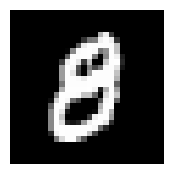

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2)) 
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

---
## Convolutional Autoencoder

Write your own CNN autoencoder. Use at least 2 blocks Convolution + ReLU + MaxPooling as _encoder_, and then an equivalent number of upsampling operations (either Transposed Convolutions+ReLU or Upsample+Conv+ReLU) followed by a Sigmoid activation.

In [6]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        ## encoder ##
        self.encoder = nn.Sequential( # YOUR CODE HERE
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),

            # nn.Conv2d(32, 32, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(32),
            # nn.MaxPool2d(2, 2)
        )
        ## decoder ##
        self.decoder = nn.Sequential ( # YOUR CODE HERE
            # nn.Upsample(scale_factor = 2, mode='nearest'),
            # nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(32),

            nn.Upsample(scale_factor = 2, mode='nearest'),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            nn.Upsample(scale_factor = 2, mode='nearest'),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        self.auto_encoder = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        return self.auto_encoder(x)
    
# initialize the NN
model = Autoencoder()

In [7]:
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Sigmoid()
  )
  (auto_encoder): Sequent

## Loss Function

Set up here a loss function that makes sense for the task at hand (look at the lesson again if you don't remember what this should be):

In [8]:
# specify loss function
criterion = nn.MSELoss() # YOUR CODE HERE

## Training

The training loop is similar to a normal training loop - however, this task is an unsupervised task. That means we do not need labels. The MNIST dataset does provide labels, of course, so we will just disregard them.

Complete the training loop below. As usual, you need to perform the forward and the backward pass.

In [9]:
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

In [10]:
import time
start_time = time.time()
# number of epochs to train the model
n_epochs = 50
if torch.cuda.is_available():
    model = model.cuda()
for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0
    epoch_s_time = time.time()
    model.train()
        
    ###################
    # train the model #
    ###################
    for data in tqdm(desc="Training", total=len(data_loaders['train']), iterable=data_loaders['train']):
        # we disregard the labels. We use the Python convention of calling
        # an unused variable "_"
        images, _ = data
        
        if torch.cuda.is_available():
            images = images.cuda()
        
        # YOUR CODE HERE
        optimizer.zero_grad()
        
        outputs = model(images)

        # calculate the loss
        loss = criterion(outputs.flatten(), images.flatten())

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item() * images.size(0)
    
    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid']):
            # _ stands in for labels, here
            images, _ = data
            
            if torch.cuda.is_available():
                images = images.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs.flatten(), images.flatten())
            
            # update running training loss
            val_loss += loss.item() * images.size(0)
    
    # print avg training statistics
    train_loss /= len(data_loaders['train'])
    val_loss /= len(data_loaders['valid'])
    elapsed_epoch_time = time.time() - epoch_s_time
    
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}, Elapsed Time: {:.2f} Seconds".format(epoch, train_loss, val_loss, elapsed_epoch_time))
elapsed_time = time.time() - start_time
print(f'Total Elapsed Time: {elapsed_time}')

Validating: 100%|██████████| 12/12 [00:15<00:00,  1.32s/it]


Epoch: 1 	Training Loss: 55.621970	Valid Loss: 15.220629, Elapsed Time: 28.819753


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Epoch: 2 	Training Loss: 10.795130	Valid Loss: 8.992465, Elapsed Time: 25.264935


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Epoch: 3 	Training Loss: 7.893981	Valid Loss: 6.972850, Elapsed Time: 24.717937


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Epoch: 4 	Training Loss: 6.664375	Valid Loss: 5.848662, Elapsed Time: 23.416825


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Epoch: 5 	Training Loss: 5.704260	Valid Loss: 5.184439, Elapsed Time: 23.116981


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Epoch: 6 	Training Loss: 5.358514	Valid Loss: 4.891931, Elapsed Time: 24.574142


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Epoch: 7 	Training Loss: 4.815887	Valid Loss: 4.353619, Elapsed Time: 23.377297


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Epoch: 8 	Training Loss: 4.490032	Valid Loss: 4.591418, Elapsed Time: 24.560827


Validating: 100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Epoch: 9 	Training Loss: 4.112867	Valid Loss: 3.852161, Elapsed Time: 26.758547


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


Epoch: 10 	Training Loss: 3.979462	Valid Loss: 3.667090, Elapsed Time: 22.016856


Validating: 100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Epoch: 11 	Training Loss: 3.882236	Valid Loss: 3.914154, Elapsed Time: 25.162077


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Epoch: 12 	Training Loss: 3.676851	Valid Loss: 3.507112, Elapsed Time: 24.299054


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Epoch: 13 	Training Loss: 3.511430	Valid Loss: 3.401146, Elapsed Time: 25.124324


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Epoch: 14 	Training Loss: 3.458124	Valid Loss: 3.344749, Elapsed Time: 23.005440


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Epoch: 15 	Training Loss: 3.261867	Valid Loss: 3.137294, Elapsed Time: 22.698385


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Epoch: 16 	Training Loss: 3.159802	Valid Loss: 3.042338, Elapsed Time: 23.596586


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Epoch: 17 	Training Loss: 3.132549	Valid Loss: 2.951587, Elapsed Time: 23.188427


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


Epoch: 18 	Training Loss: 2.999881	Valid Loss: 2.892202, Elapsed Time: 21.623592


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s]


Epoch: 19 	Training Loss: 2.957669	Valid Loss: 2.885330, Elapsed Time: 22.312118


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.09it/s]


Epoch: 20 	Training Loss: 2.932677	Valid Loss: 2.736081, Elapsed Time: 23.290252


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Epoch: 21 	Training Loss: 2.834895	Valid Loss: 3.098193, Elapsed Time: 22.862552


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


Epoch: 22 	Training Loss: 2.887609	Valid Loss: 2.705186, Elapsed Time: 23.717427


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


Epoch: 23 	Training Loss: 2.748338	Valid Loss: 2.572703, Elapsed Time: 22.453730


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Epoch: 24 	Training Loss: 2.638723	Valid Loss: 2.542234, Elapsed Time: 24.133933


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


Epoch: 25 	Training Loss: 2.567017	Valid Loss: 2.617886, Elapsed Time: 22.824761


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Epoch: 26 	Training Loss: 2.592313	Valid Loss: 2.461363, Elapsed Time: 22.472572


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Epoch: 27 	Training Loss: 2.514690	Valid Loss: 2.453387, Elapsed Time: 22.555874


Validating: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


Epoch: 28 	Training Loss: 2.486399	Valid Loss: 2.400730, Elapsed Time: 23.431664


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Epoch: 29 	Training Loss: 2.554126	Valid Loss: 2.483391, Elapsed Time: 22.130831


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Epoch: 30 	Training Loss: 2.498237	Valid Loss: 2.341636, Elapsed Time: 23.006231


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]


Epoch: 31 	Training Loss: 2.459600	Valid Loss: 2.413769, Elapsed Time: 22.597860


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Epoch: 32 	Training Loss: 2.471050	Valid Loss: 2.366933, Elapsed Time: 23.686426


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Epoch: 33 	Training Loss: 2.351038	Valid Loss: 2.315159, Elapsed Time: 23.107766


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Epoch: 34 	Training Loss: 2.370522	Valid Loss: 2.287537, Elapsed Time: 23.556124


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Epoch: 35 	Training Loss: 2.317768	Valid Loss: 2.257689, Elapsed Time: 23.326960


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


Epoch: 36 	Training Loss: 2.351981	Valid Loss: 2.259194, Elapsed Time: 24.108102


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


Epoch: 37 	Training Loss: 2.291386	Valid Loss: 2.214536, Elapsed Time: 24.380874


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Epoch: 38 	Training Loss: 2.295934	Valid Loss: 2.250135, Elapsed Time: 24.534825


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Epoch: 39 	Training Loss: 2.218292	Valid Loss: 2.166633, Elapsed Time: 22.709203


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.09it/s]


Epoch: 40 	Training Loss: 2.222223	Valid Loss: 2.141315, Elapsed Time: 23.557539


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Epoch: 41 	Training Loss: 2.207010	Valid Loss: 2.113814, Elapsed Time: 22.163535


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Epoch: 42 	Training Loss: 2.264683	Valid Loss: 2.344871, Elapsed Time: 23.283975


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Epoch: 43 	Training Loss: 2.190663	Valid Loss: 2.122603, Elapsed Time: 23.874651


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Epoch: 44 	Training Loss: 2.159250	Valid Loss: 2.084632, Elapsed Time: 23.406974


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Epoch: 45 	Training Loss: 2.147052	Valid Loss: 2.131597, Elapsed Time: 23.095250


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


Epoch: 46 	Training Loss: 2.246307	Valid Loss: 2.060936, Elapsed Time: 23.341779


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Epoch: 47 	Training Loss: 2.136541	Valid Loss: 2.084614, Elapsed Time: 22.867810


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Epoch: 48 	Training Loss: 2.117927	Valid Loss: 2.088386, Elapsed Time: 23.081075


Validating: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Epoch: 49 	Training Loss: 2.095183	Valid Loss: 2.029305, Elapsed Time: 22.759664


Validating: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

Epoch: 50 	Training Loss: 2.084539	Valid Loss: 2.034747, Elapsed Time: 21.786709
Total Elapsed Time: 1181.04509973526


In [11]:
# Epoch: 50 	Training Loss: 1.359510	Valid Loss: 1.399772

## Finding Anomalies
Now that our autoencoder is trained we can use it to find anomalies. Let's consider the test set. We loop over all the batches in the test set and we record the value of the loss for each example separately. The examples with the highest reconstruction loss are our anomalies. 

Indeed, if the reconstruction loss is high, that means that our trained autoencoder could not reconstruct them well. Indeed, what the autoencoder learned about our dataset during training is not enough to describe these examples, which means they are different than what the encoder has seen during training, i.e., they are anomalies (or at least they are the most uncharacteristic examples).

Let's have a look:

In [12]:
# Since this dataset is small we collect all the losses as well as
# the image and its reconstruction in a dictionary. In case of a
# larger dataset you might have to save on disk
# (won't fit in memory)
losses = {}

# We need the loss by example (not by batch)
loss_no_reduction = nn.MSELoss(reduction='none')

idx = 0

with torch.no_grad():
    for data in tqdm(desc="Testing", total=len(data_loaders['test']),
            iterable=data_loaders['test']
        ):

            images, _ = data
            
            if torch.cuda.is_available():
                images = images.cuda()
                        
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            
            # calculate the loss
            loss = loss_no_reduction(outputs, images)
            
            # Accumulate results per-example
            for i, l in enumerate(loss.mean(dim=[1, 2, 3])):
                losses[idx + i] = {
                    'loss': float(l.cpu().numpy()),
                    'image': images[i].cpu().numpy(),
                    'reconstructed': outputs[i].cpu().numpy()
                }
            
            idx += loss.shape[0]

# Let's save our results in a pandas DataFrame
df = pd.DataFrame(losses).T
df.head()

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Testing: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


,loss,image,reconstructed
0,0.001193,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.013495013, 0.003408866, 0.0035804627, 0.0..."
1,0.001739,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.013495013, 0.0037094443, 0.004121124, 0.0..."
2,0.000567,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.013495013, 0.003408866, 0.0035804627, 0.0..."
3,0.001817,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.013495013, 0.003408866, 0.0035804627, 0.0..."
4,0.001618,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.013495013, 0.0034091838, 0.003578483, 0.0..."


Let's now display the histogram of the loss. The elements on the right (with the higher loss) are the most uncharacteristic examples. Feel free to look into `helpers.py` to see how these plots are made:

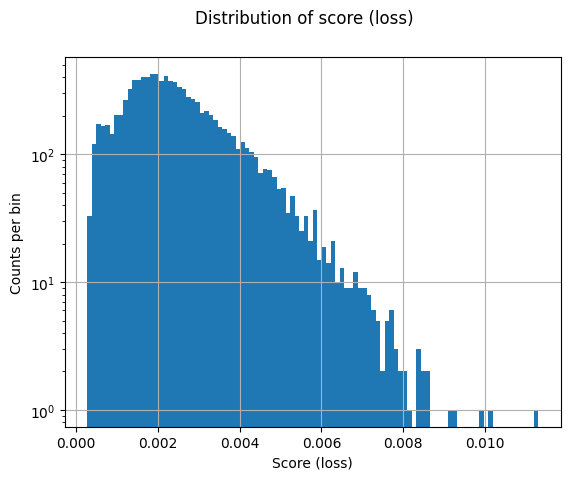

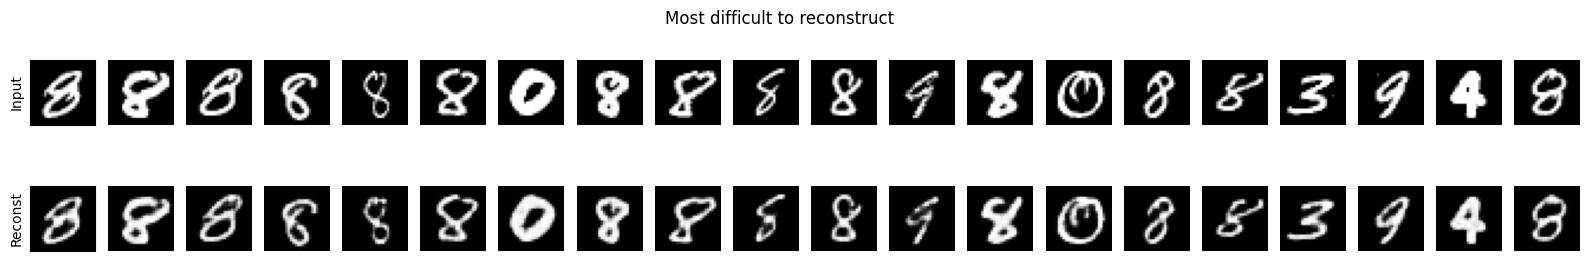

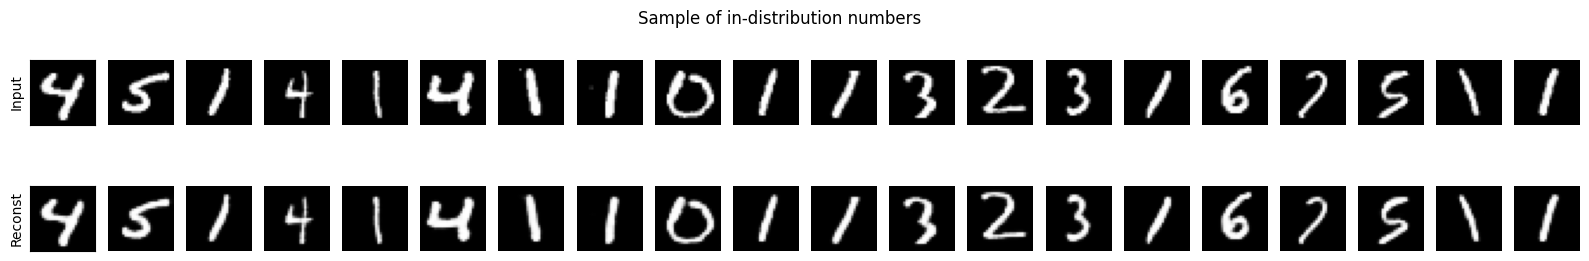

In [13]:
from helpers import anomaly_detection_display

anomaly_detection_display(df)

We got similar results as in the case of linear autoencoders, but the loss is on average much smaller (a sign that the network is much more capable of representing and reconstructing the dataset).